# Screencast
I brought a few questions we will be exploring throughout this lesson. 
First, let's take a look at the data and how to exact it and then see how to answer the first question about how to break into the field of becoming a software developoer according to the survey results.

### After partition dataset into k clusters, what about developer distribution? 
Step1:let's read in the necessary libraries we will need to wrangle our data

In [20]:

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier

In [118]:
#load survey results from the csv file
out_dir = 'data/'
df = pd.read_csv(out_dir+'survey_results_public.csv')
df.head()


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df2 = pd.read_csv(out_dir + 'survey_results_schema.csv')
list(df2[df2.Column == 'CareerSatisfaction']['Question'])

['Career satisfaction rating']

In [27]:
#Let's have a look at what the participants say
study = df['CareerSatisfaction'].value_counts().reset_index()
study.head()

,index,CareerSatisfaction
0,8.0,11037
1,7.0,9384
2,9.0,5579
3,10.0,5408
4,6.0,4721


Extract data from survey data frame and remove irrelevant features and finially create a new data csv file

In [29]:
#Remove Columns with only One Value
df = df.loc[:,df.apply(pd.Series.nunique) != 1]
# drop the original categories column from `df`
drop_list = ['Respondent']
df = df.drop(drop_list,axis=1)


In [102]:
# get the relevant features from data frame
df3 = df[['Professional', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize', 'CompanyType', 'YearsProgram', 'YearsCodedJob',
       'YearsCodedJobPast', 'DeveloperType', 'WebDeveloperType',
       'MobileDeveloperType', 'NonDeveloperType', 'CareerSatisfaction',
       'JobSatisfaction']]
#df3 = df[['Professional', 'Country', 'University',
#       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
#       'CompanySize', 'CompanyType', 'YearsProgram', 'YearsCodedJob',
#       'YearsCodedJobPast', 'DeveloperType', 'WebDeveloperType',
#       'MobileDeveloperType', 'NonDeveloperType', 'CareerSatisfaction',
#       'JobSatisfaction','Salary']]
df3

,Professional,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction
2,Professional developer,United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",Publicly-traded corporation,20 or more years,20 or more years,NaN,Other,NaN,NaN,NaN,8.0,9.0
14,Professional developer,United Kingdom,No,Employed full-time,Professional degree,Computer engineering or electrical/electronics...,All or almost all the time (I'm full-time remote),"5,000 to 9,999 employees",Publicly-traded corporation,20 or more years,20 or more years,NaN,Embedded applications/devices developer,NaN,NaN,NaN,8.0,8.0
17,Professional developer,United States,"Yes, part-time",Employed full-time,Bachelor's degree,Computer science or software engineering,All or almost all the time (I'm full-time remote),"1,000 to 4,999 employees",Publicly-traded corporation,20 or more years,20 or more years,NaN,Web developer; Embedded applications/devices d...,NaN,NaN,NaN,9.0,8.0
18,Professional developer,United States,No,Employed full-time,Bachelor's degree,Computer science or software engineering,A few days each month,"10,000 or more employees",Publicly-traded corporation,2 to 3 years,3 to 4 years,NaN,Web developer,Full stack Web developer,NaN,NaN,5.0,3.0
22,Professional developer,Israel,No,Employed full-time,Bachelor's degree,Computer engineering or electrical/electronics...,A few days each month,500 to 999 employees,"Privately-held limited company, not in startup...",10 to 11 years,5 to 6 years,NaN,Other,NaN,NaN,NaN,8.0,9.0
25,Professional developer,United States,No,Employed full-time,Master's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",Publicly-traded corporation,20 or more years,16 to 17 years,NaN,Web developer,Back-end Web developer,NaN,NaN,7.0,7.0
34,Professional developer,Croatia,"Yes, full-time",Employed full-time,Bachelor's degree,Computer engineering or electrical/electronics...,A few days each month,10 to 19 employees,"Privately-held limited company, not in startup...",7 to 8 years,1 to 2 years,NaN,Embedded applications/devices developer,NaN,NaN,NaN,10.0,8.0
36,Professional developer,Argentina,No,Employed full-time,Some college/university study without earning ...,Computer programming or Web development,A few days each month,500 to 999 employees,"Sole proprietorship or partnership, not in sta...",20 or more years,9 to 10 years,NaN,Web developer; Mobile developer; Desktop appli...,NaN,NaN,NaN,7.0,9.0
52,Professional developer,Brazil,No,Employed full-time,Bachelor's degree,Computer engineering or electrical/electronics...,A few days each month,"1,000 to 4,999 employees","Sole proprietorship or partnership, not in sta...",4 to 5 years,1 to 2 years,NaN,Web developer; Mobile developer; Quality assur...,NaN,NaN,NaN,6.0,5.0
54,Professional developer,Germany,No,Employed full-time,Master's degree,Computer science or software engineering,A few days each month,"1,000 to 4,999 employees",I don't know,8 to 9 years,4 to 5 years,NaN,Web developer,Back-end Web developer,NaN,NaN,9.0,9.0


In [103]:
#Save to CSV
df3.to_csv(out_dir+"survey_results_public_less_features.csv",index=False)

In [104]:
# load dataset
raw_data = pd.read_csv(out_dir + 'survey_results_public_less_features.csv')
raw_data2 = raw_data
print(raw_data2)

                 Professional         Country      University  \
0      Professional developer  United Kingdom              No   
1      Professional developer  United Kingdom              No   
2      Professional developer   United States  Yes, part-time   
3      Professional developer   United States              No   
4      Professional developer          Israel              No   
...                       ...             ...             ...   
12842  Professional developer     Netherlands              No   
12843  Professional developer          Cyprus              No   
12844  Professional developer          France              No   
12845  Professional developer   United States              No   
12846  Professional developer   United States              No   

         EmploymentStatus      FormalEducation  \
0      Employed full-time    Bachelor's degree   
1      Employed full-time  Professional degree   
2      Employed full-time    Bachelor's degree   
3      Employed ful

In [105]:
# data review and verification
print('{:*^50}'.format('Data overview:'))
print(raw_data.head(2))  # print first two data rows
print('{:*^50}'.format('Data dtypes:'))
print(pd.DataFrame(raw_data.dtypes).T)  # print data distribution
print('{:*^50}'.format(' NA counts:'))
print(pd.DataFrame(raw_data.isnull().sum()).T)  # view missing data
print('{:*^50}'.format('Data DESC:'))
print(raw_data.describe().round(2).T)  # Print raw data basic descriptive information
print('{:*^50}'.format('Correlation analysis:'))
print(raw_data.corr().round(2).T)  # Print raw data correlation information

******************Data overview:******************
             Professional         Country University    EmploymentStatus  \
0  Professional developer  United Kingdom         No  Employed full-time   
1  Professional developer  United Kingdom         No  Employed full-time   

       FormalEducation                                     MajorUndergrad  \
0    Bachelor's degree           Computer science or software engineering   
1  Professional degree  Computer engineering or electrical/electronics...   

                                          HomeRemote  \
0  Less than half the time, but at least one day ...   
1  All or almost all the time (I'm full-time remote)   

                CompanySize                  CompanyType      YearsProgram  \
0  10,000 or more employees  Publicly-traded corporation  20 or more years   
1  5,000 to 9,999 employees  Publicly-traded corporation  20 or more years   

      YearsCodedJob YearsCodedJobPast  \
0  20 or more years               NaN   
1 

In [106]:
# String classification to integer classification
df = pd.DataFrame(raw_data2)

conver_cols = df.columns

convert_matrix = raw_data2[conver_cols]  # Get the all feature array to convert

for each_col in conver_cols:  # Convert by each column
    each_data = convert_matrix[each_col]  # Get each column data
    model_le = LabelEncoder()  # Builde model objects    
    
    if np.issubdtype(each_data.dtype, np.number):
        each_con_data = each_data.astype(str)
    else:
        each_con_data = model_le.fit_transform(each_data.astype(str))  # convert directly
        
    convert_matrix[each_col] = each_con_data  # Replace the original value with the converted value
    convert_matrix[each_col] = convert_matrix[each_col].replace('nan', 0) #Replace all 'nan' value to 0

In [107]:
#Handle OneHotEncode conversion for numeric index
model_onehotencode = OneHotEncoder(sparse=False)  # build OneHotEncode object
ohe_matrix = model_onehotencode.fit_transform(convert_matrix)  # convert directly

# Data standardization
scale_matrix = raw_data2.iloc[:, 1:len(conver_cols)].select_dtypes(include=[np.number])  # Get the matrix to be converted

minmax_scaler = MinMaxScaler()  # build MinMaxScaler model object
data_scaled = minmax_scaler.fit_transform(scale_matrix)  # MinMaxScaler standardization

# Merge all input dimensions
X = np.hstack((data_scaled, ohe_matrix))

E:\Anaconda3_W12\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
E:\Anaconda3_W12\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


12847
12847


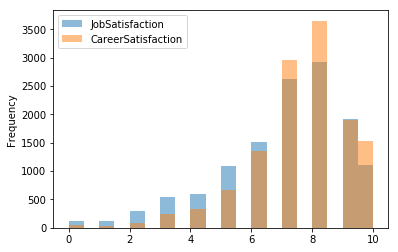

In [108]:
#Investigating FICO Score of 'JobSatisfaction','CareerSatisfaction'
fico_columns = ['JobSatisfaction','CareerSatisfaction']
#print(df.shape[0])
df.dropna(subset=fico_columns,inplace=True)
#print(df.shape[0])
df[fico_columns].plot.hist(alpha=0.5,bins=20);

In [144]:
meaning = [
"Strongly boring",
"very very boring",
"very boring",
"boring",
"So so",
"Accepted",
"Like it",
"Statisficated",
"Very statisficated",
"Very very statificated",
"Strongly statificated"
]
#status, count = df["JobSatisfaction"].value_counts().index, df["JobSatisfaction"].value_counts().values
groupby_df = df.groupby('JobSatisfaction')
status, count = groupby_df["JobSatisfaction"].value_counts(), groupby_df["JobSatisfaction"].value_counts().values

jobsatisfaction_explanation = pd.DataFrame({'Job Satisfaction': status,'Meaning': meaning})[['Job Satisfaction','Meaning']]
jobsatisfaction_explanation

,,Job Satisfaction,Meaning
JobSatisfaction,JobSatisfaction,,
0.0,0.0,467,Strongly boring
1.0,1.0,373,very very boring
2.0,2.0,888,very boring
3.0,3.0,1635,boring
4.0,4.0,1865,So so
5.0,5.0,3749,Accepted
6.0,6.0,4726,Like it
7.0,7.0,7969,Statisficated
8.0,8.0,8983,Very statisficated


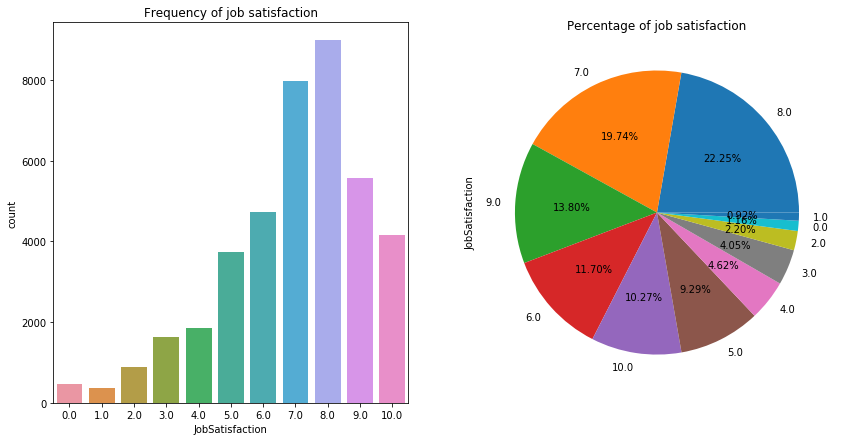

In [145]:
filtered_df = df
fig, axs = plt.subplots(1,2,figsize=(14,7))

sns.countplot(x='JobSatisfaction',data=filtered_df,ax=axs[0])
axs[0].set_title("Frequency of job satisfaction")
filtered_df.JobSatisfaction.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of job satisfaction")
plt.show()

*******Detailed features for all clusters:********


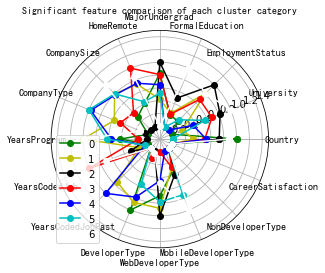

In [113]:
# Feature analysis for clustering results
# prepare the label and data of training set
cluster_labels = pd.DataFrame(cluster_labels_k, columns=['clusters'])  # Get the label information under the training set
merge_data = pd.concat((convert_matrix, cluster_labels), axis=1)  # Integrate raw processed data with clustering tags

clustering_count = pd.DataFrame(
    merge_data['CareerSatisfaction'].groupby(merge_data['clusters']).count()).T.rename(
    {'CareerSatisfaction': 'counts'})  # Calculate the sample size for each cluster category
clustering_ratio = (clustering_count / len(merge_data)).round(2).rename(
    {'counts': 'percentage'})  # Calculate the proportion of sample size for each cluster category

cluster_features = []  # An empty list for storing all feature information after the final merge
for cluster_line in range(best_k):  # Read each class index        
    label_data = merge_data[merge_data['clusters'] == cluster_line]  # Get data for a specific class
    numeric_data1 = label_data.iloc[:, 1:18]  # Obtain numerical data features
    numeric_desc1 = numeric_data1.describe().round(3)  # Get descriptive statistics for numeric features    
    merge_data1 = numeric_desc1.iloc[2, :]  # Get the mean of the numerical features
    
    numeric_data2 = label_data.iloc[:, 17:-1]  # Get string data features
    numeric_desc2 = numeric_data2.describe(include='all')  # Get descriptive statistics for string data functionality
    merge_data2 = numeric_desc2.iloc[2, :]  # Get the most frequent values ​​of string data features

    merge_line = pd.concat((merge_data1, merge_data2), axis=0)  # Combine numeric and string typical features along the line
    merge_line.name = str(cluster_line)
    cluster_features.append(merge_line)  # Append data characteristics under each category to the list

kcluster_pd = pd.DataFrame(cluster_features).T  # Convert a list to a matrix
print('{:*^50}'.format('Detailed features for all clusters:'))
all_kcluster_set = pd.concat((clustering_count, clustering_ratio, kcluster_pd), axis=0)  # Combine all the information for each cluster category

# Significant numerical feature comparison of each category
num_cluster_sets = kcluster_pd.iloc[:17, :].T.astype(np.float64)  # Get the data to show
num_cluster_sets_max_min = minmax_scaler.fit_transform(num_cluster_sets)  # Obtain standardized data

fig = plt.figure()  # Building a canvas
ax = fig.add_subplot(111, polar=True)  # Increase the subgrid to the polar parameter
labels = np.array(merge_data1.index)  # Set the data labels to display
labels = np.concatenate((labels, ['CareerSatisfaction'])) 
cor_list = [ 'g', 'y', 'k', 'r', 'b', 'c', 'w', 'm', 'z', 'a', 'd','e','f','h', 'i','j','l']  # Define different categories of colors
cluster_angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # Calculate the angle of each interval
cluster_angles = np.concatenate((cluster_angles, [cluster_angles[0]]))  # Create the same head and tail fields to close

for i in range(len(num_cluster_sets)):  # Loop each category
    data_tmp = num_cluster_sets_max_min[i, :]  # Get the corresponding class data
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # Create the same head and tail fields to close    
    ax.plot(cluster_angles, data, 'o-', c=cor_list[i], label=i)  # Draw lines

ax.set_thetagrids(cluster_angles * 180 / np.pi, labels, fontproperties="SimHei")  # Set the polar axis
ax.set_title("Significant feature comparison of each cluster category", fontproperties="SimHei")  # Set title
ax.set_rlim(-0.2, 1.5)  # Set the axis scale range
plt.legend(loc=0)  # Set the legend position
plt.show()  # Display image for clustering


### display features importance --Which features are more important for CareerSatisfaction？(show top 3)

In [147]:
names = raw_data2.columns
dataframe = convert_matrix
array = dataframe.values
featurenumber = len(raw_data2.columns)
X = array[:,0:featurenumber-2]
Y = array[:,featurenumber-1]
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
importance_value = model.feature_importances_
feature_index = np.array(importance_value).argpartition(-2)[-6:]
print(names[feature_index[0]])
print(names[feature_index[1]])
print(names[feature_index[2]])
print(names[feature_index[3]])
print(names[feature_index[4]])
print(names[feature_index[5]])

E:\Anaconda3_W12\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Country
CompanySize
MajorUndergrad
DeveloperType
YearsProgram
YearsCodedJob


### Question3: These features are linear correlation or non-linear correlation?

                     Professional   Country  University  EmploymentStatus  \
Professional                  NaN       NaN         NaN               NaN   
Country                       NaN  1.000000   -0.089749         -0.069118   
University                    NaN -0.089749    1.000000          0.270151   
EmploymentStatus              NaN -0.069118    0.270151          1.000000   
FormalEducation               NaN -0.062624    0.089291          0.081780   
MajorUndergrad                NaN -0.075140    0.080147          0.075684   
HomeRemote                    NaN -0.051489    0.021757          0.014290   
CompanySize                   NaN -0.032321    0.011004          0.022171   
CompanyType                   NaN  0.031988   -0.047585         -0.028798   
YearsProgram                  NaN -0.002311    0.050274          0.041156   
YearsCodedJob                 NaN -0.003785   -0.010929         -0.019581   
YearsCodedJobPast             NaN  0.008395    0.002969          0.003302   

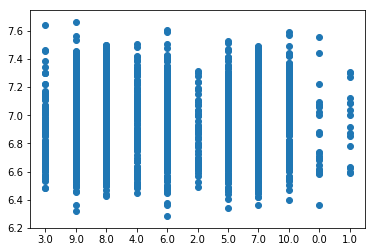

In [116]:
#verify those features are linear correlations -- These features are linear correlation or non-linear correlation?
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#split dataset and target
inpurt_train, input_test, output_train, output_test = train_test_split(X, Y, test_size=0.2, random_state=101)
lm = LinearRegression()
lm.fit(inpurt_train,output_train)
predictions = lm.predict(input_test)
print(dataframe.corr())
plt.scatter(output_test,predictions) # from the result, we can see those features are non-linear corelation